In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
import scipy.optimize as opt

In [2]:
star1_x = 10
star1_y = 7

star2_x = -3
star2_y = -4

I1 = 10000
I2 = 7000

cmin = -50
cmax = 50

mean_seeing = 3

In [3]:
def generate_coords(x, y):
    coords = np.empty( (len(x), len(y), 2), dtype=np.intp)
    coords[..., 0] = x[:, None]
    coords[..., 1] = y

    return coords.reshape( len(x)**2, 2 )

In [4]:
def AiryDisk(x, x0, I):
    
    xc = x[:, 0]
    yc = x[:, 1]
    
    q = np.sqrt( (xc - x0[0])**2 + (yc - x0[1])**2 )
    
    result = I * (2 * special.j1(q) / q )**2
    
    intensities = np.nan_to_num(result, nan=I)
    
    return intensities.reshape( (len(intensities), 1))


In [5]:
def GenerateImage(Nmeas):
    
    x = np.arange(cmin, cmax+1)
    y = np.arange(cmin, cmax+1)
    
    coords = generate_coords(x, y)
    
    data = []
    
    for n in range(Nmeas):
    
        x1 = np.random.normal(star1_x, mean_seeing)
        y1 = np.random.normal(star1_y, mean_seeing)
        
        x2 = np.random.normal(star2_x, mean_seeing)
        y2 = np.random.normal(star2_y, mean_seeing)
        
        i1 = np.random.poisson(AiryDisk(coords, [x1, y1], I1))
        
        i2 = np.random.poisson(AiryDisk(coords, [x2, y2], I2))
        
        intensities = i1 + i2
        
        image_data = np.hstack([coords, intensities])
        
        data.append(image_data)
        
    return data

In [6]:
data = GenerateImage(5)

In [7]:
a = data[0]

In [8]:
a.shape

(10201, 3)

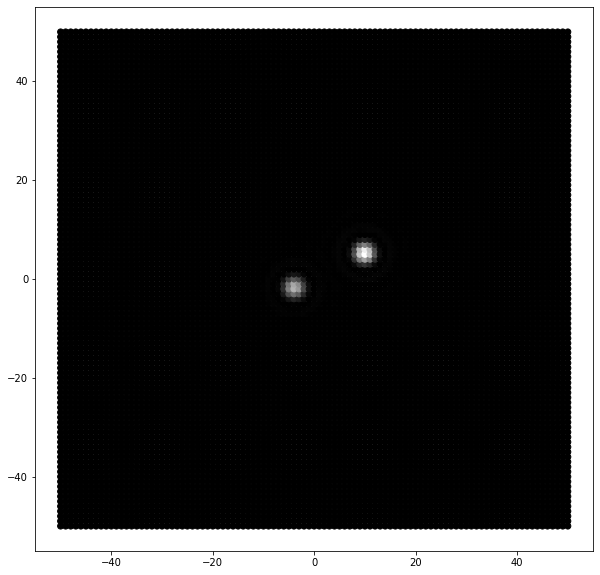

In [9]:
# plot every time

plt.figure(figsize = [10, 10])
plt.scatter( a[:, 0], a[:, 1], c=a[:, 2])
plt.gray()
plt.show()

In [10]:
def square_distance(data, centers):
    
    points = np.transpose(np.vstack( [data[:, 0], data[:, 1]] ))

    
    differences = [points - center for center in centers]
    
    sq_differences = np.array( [np.sum(difference**2, axis=1) for difference in differences] )
    
    return sq_differences

def generate_assignment(square_distances):
    
    correspondence = np.stack(square_distances, axis=1)
    
    assignments = np.argmin(correspondence, axis=1)
    
    return assignments

def calculate_centroids(data, assignments, no_centers=2):
    
    points = np.transpose(np.vstack( [data[:, 0], data[:, 1]] ))
    
    weights = data[:, 2]
    
    centroids = []
    
    for i in range(no_centers):
        point_split = points[np.equal(assignments, i)]
        weights_split = weights[np.equal(assignments, i)]
        
        centx = np.sum( weights_split * point_split[:, 0]) / np.sum(weights)
        centy = np.sum( weights_split * point_split[:, 1]) / np.sum(weights)
        
        centroids.append(np.array([centx, centy]))
        
    return np.array(centroids)

# plot last every time, plot all if verbose
def plot_correspondence(points, assignments, centers, name='default_name'):
    
    plt.figure(figsize=[12,12])
        
    plt.scatter(points[:, 0], points[:, 1], c=plt.cm.Set1(assignments))
    
    plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=100,\
                c=plt.cm.Set1(np.arange(0, len(centers))), edgecolors='k')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.title(name)
    
    plt.show()

In [11]:
weights = a[:, 2]

# mind the name collision here
data = a[ weights != 0 ]

In [12]:
def k_clustering(data, no_clusters=2, verbose=False):
    
    # generate random initial center positions
    centers = np.stack([np.random.uniform(low=cmin, high=cmax, size=no_clusters),\
                        np.random.uniform(low=cmin, high=cmax, size=no_clusters)], axis=1)
    # keep track of iterations
    i = 0

    while True:

        square_distances = square_distance(data, centers)

        assignments = generate_assignment(square_distances)
        
        if verbose:
            
            plot_correspondence(data, assignments, centers, name='Iteration {}'.format(i))

        new_centers = calculate_centroids(data, assignments)
        
        # clustering converges when the centers don't change
        if np.array_equal(centers, new_centers):
            
            print('Assignments Converged!')
            print('Centers are:')
            print(centers)
            
            
            return centers, assignments

        else:

            i += 1
            centers = new_centers

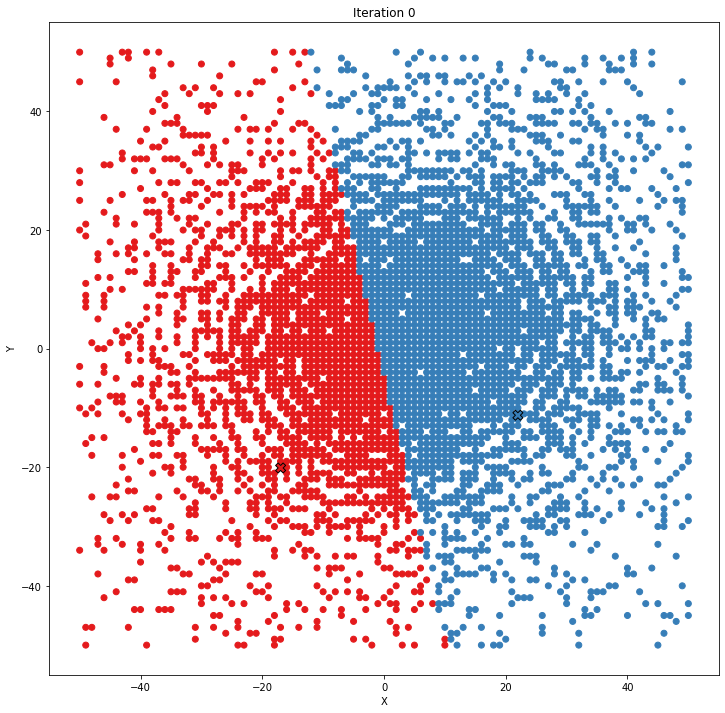

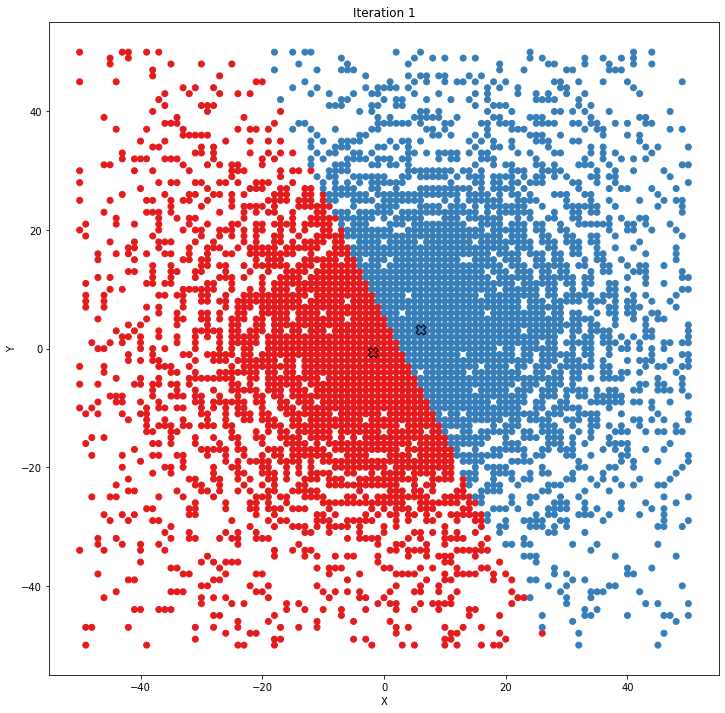

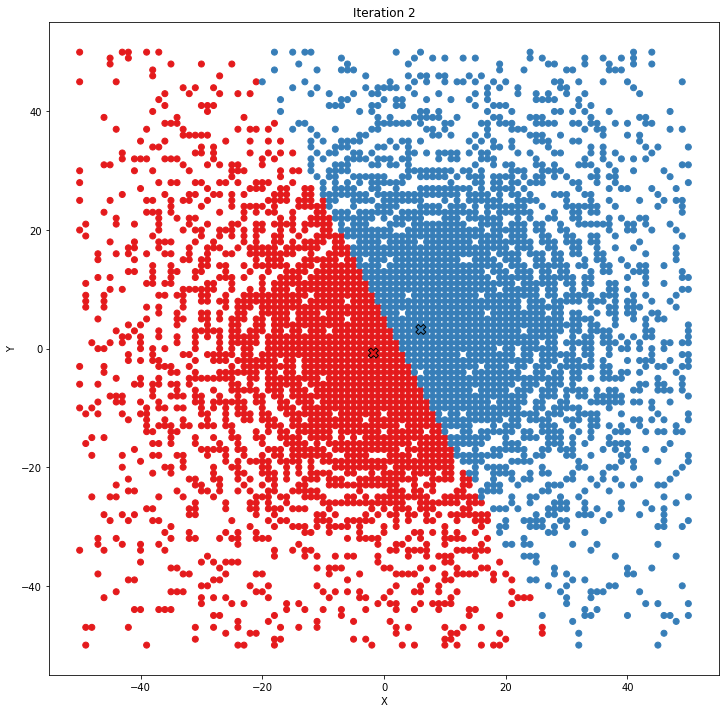

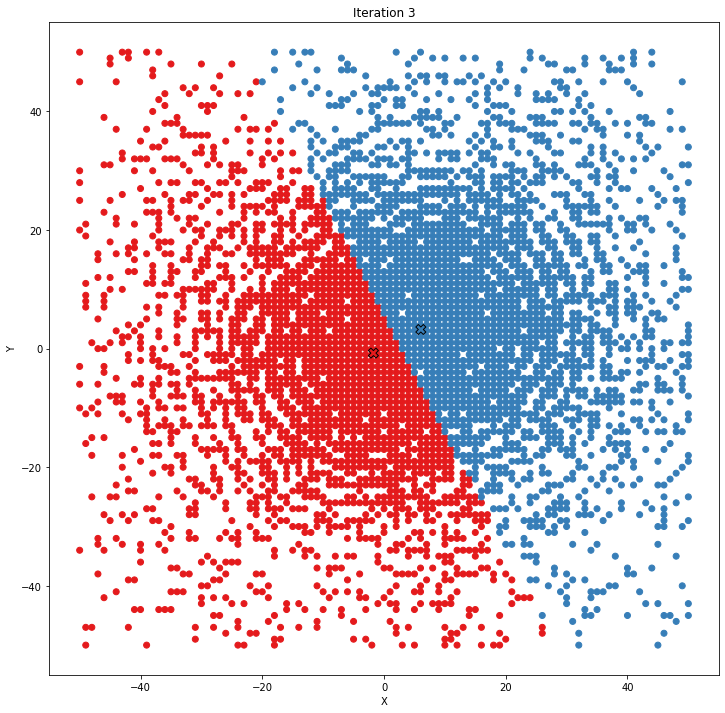

Assignments Converged!
Centers are:
[[-1.739226   -0.75183483]
 [ 6.04997009  3.22746694]]


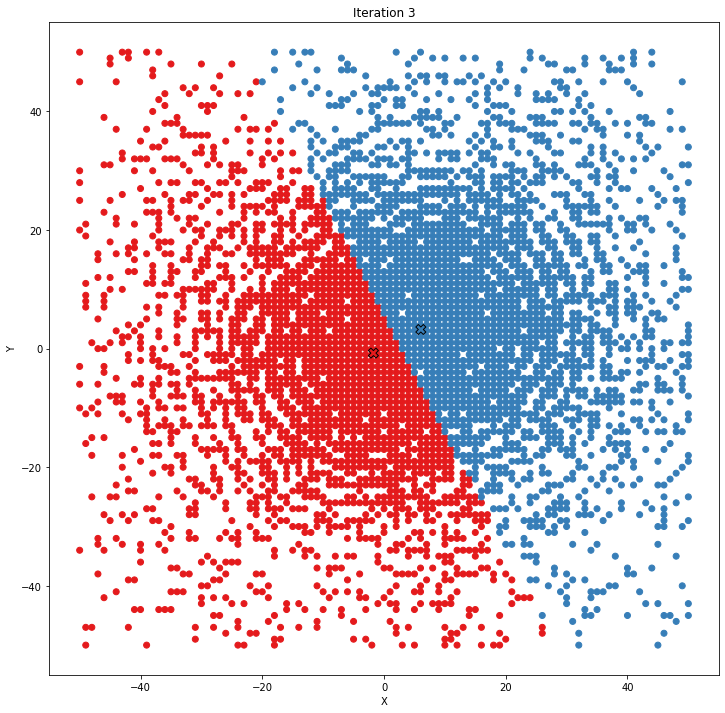

In [13]:
centers, assignments = k_clustering(data, verbose=True)

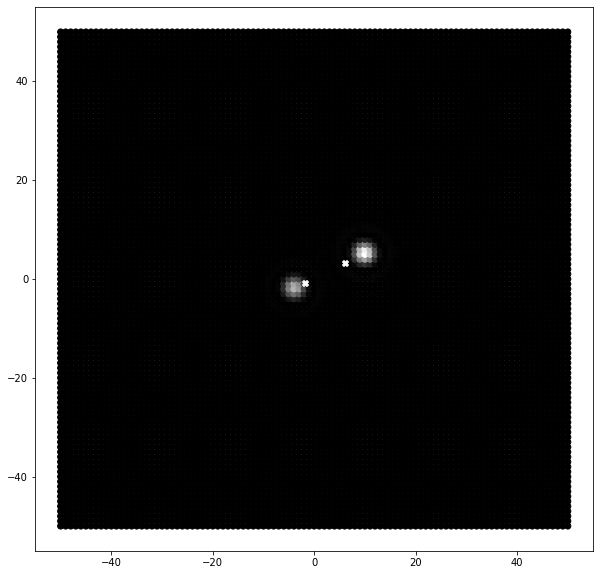

In [14]:
plt.figure(figsize = [10, 10])
plt.scatter( a[:, 0], a[:, 1], c=a[:, 2])

plt.gray()

plt.scatter( centers[:, 0], centers[:, 1], marker='X', color='w')

plt.show()

In [15]:
# remember to do this filtering

star1 = data[assignments == 0]
star2 = data[assignments == 1]

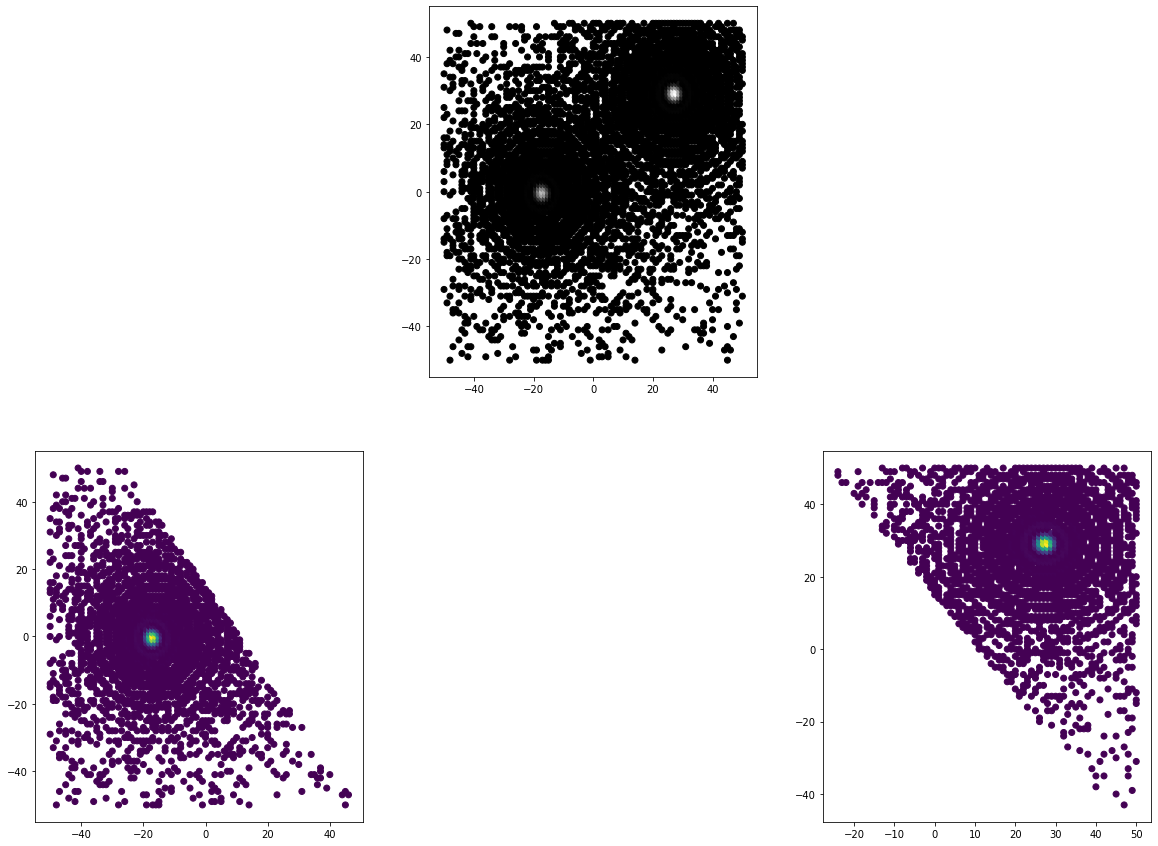

In [40]:
# plot this every time

fig, ax = plt.subplots(2, 3, figsize=[20,15])

ax[0,1].scatter( data[:, 0], data[:, 1], c=data[:, 2], cmap='gray')
ax[1,0].scatter( star1[:, 0], star1[:, 1], c=star1[:, 2])
ax[1,2].scatter( star2[:, 0], star2[:, 1], c=star2[:, 2])
ax[0,0].set_axis_off()
ax[0,2].set_axis_off()
ax[1,1].set_axis_off()
plt.gray()
plt.show()

In [17]:
# remember to do this filtering; allow for a variable threshold

w1 = star1[:, 2]
m1 = np.amax(w1)

signal1 = star1[ w1 > 0.01*m1]

w2 = star2[:, 2]
m2 = np.amax(w2)

signal2 = star2[ w2 > 0.01*m2]

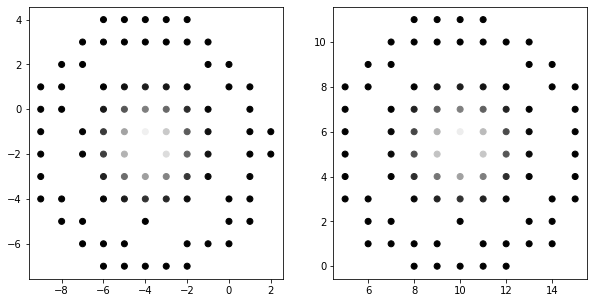

In [18]:
# don't plot

fig, ax = plt.subplots(1, 2, figsize=[10,5])
ax[0].scatter( signal1[:, 0], signal1[:, 1], c=signal1[:, 2])
ax[1].scatter( signal2[:, 0], signal2[:, 1], c=signal2[:, 2])

plt.gray()
plt.show()

In [19]:
def gauss2d(xy, amp, x0, y0, a, b, c):
    x = xy[0]
    y = xy[1]
    arg = a * (x - x0)**2 + 2 * b * (x - x0) * (y - y0) + c * (y - y0)**2
    
    return amp * np.exp(-arg)

In [20]:
import scipy.optimize as opt

def fit_gauss2d(data):
    
    max_arg = np.argmax( data[:, 2] )
    
    guess = [1, data[max_arg, 0], data[max_arg, 1], 1, 1, 1]
    
    x = data[:, 0]
    y = data[:, 1]
    xy = [x, y]
    
    pred_params, uncert_cov = opt.curve_fit( gauss2d, xy, data[:, 2], p0=guess)
    
    return pred_params, uncert_cov

In [27]:
def get_predicted_mean(data):
    
    pred, cov = fit_gauss2d(data)
    
    unc = np.sqrt(np.diag(cov))
    
    x = pred[1]
    y = pred[2]
    
    ux = unc[1]
    uy = unc[2]
    
    return np.array( [x, y] ), np.array( [ux, uy] )
    

In [28]:
get_predicted_mean(signal1)

(array([-3.82101095, -1.63299755]), array([0.01183908, 0.01187417]))

In [21]:
pred1, cov1 = fit_gauss2d(signal1)

unc1 = np.sqrt(np.diag(cov1))

In [22]:
pred_x = pred1[1]
pred_y = pred1[2]

print('Predicted Values')
print( pred_x, pred_y )

unc_x = unc1[1]
unc_y = unc1[2]

print(unc_x, unc_y)

print('Actual Values')

print(star1_x, star1_y)

Predicted Values
-3.8210109531171206 -1.632997550068405
0.011839083409512608 0.011874170101112714
Actual Values
10 7


In [3]:
# global variables

# image size
cmin = -50
cmax = 50

# calculates the square distance between
# points and cluster centers
def square_distance(data, centers):
    
    points = np.transpose(np.vstack( [data[:, 0], data[:, 1]] ))

    
    differences = [points - center for center in centers]
    
    sq_differences = np.array( [np.sum(difference**2, axis=1) for difference in differences] )
    
    return sq_differences

# assigns the points to cluster centers by
# square distance
def generate_assignment(square_distances):
    
    correspondence = np.stack(square_distances, axis=1)
    
    assignments = np.argmin(correspondence, axis=1)
    
    return assignments

# calculates the cluster centroids by calculating
# the flux-weighted average of the points
def calculate_centroids(data, assignments, no_centers=2):
    
    points = np.transpose(np.vstack( [data[:, 0], data[:, 1]] ))
    
    weights = data[:, 2]
    
    centroids = []
    
    for i in range(no_centers):
        point_split = points[np.equal(assignments, i)]
        weights_split = weights[np.equal(assignments, i)]
        
        centx = np.sum( weights_split * point_split[:, 0]) / np.sum(weights)
        centy = np.sum( weights_split * point_split[:, 1]) / np.sum(weights)
        
        centroids.append(np.array([centx, centy]))
        
    return np.array(centroids)

# plots the correspondence between cluster centers and points
# plot last every time, plot all if verbose
def plot_correspondence(points, assignments, centers, name='default_name'):
    
    plt.figure(figsize=[12,12])
        
    plt.scatter(points[:, 0], points[:, 1], c=plt.cm.Set1(assignments))
    
    plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=100,\
                c=plt.cm.Set1(np.arange(0, len(centers))), edgecolors='k')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    
    plt.title(name)
    
    plt.show()

def k_clustering(data, no_clusters=2, verbose=False):
    
    # generate random initial center positions
    centers = np.stack([np.random.uniform(low=cmin, high=cmax, size=no_clusters),\
                        np.random.uniform(low=cmin, high=cmax, size=no_clusters)], axis=1)
    # keep track of iterations
    i = 0

    while True:

        square_distances = square_distance(data, centers)

        assignments = generate_assignment(square_distances)
        
        if verbose:
            
            plot_correspondence(data, assignments, centers, name='Iteration {}'.format(i))

        new_centers = calculate_centroids(data, assignments)
        
        # clustering converges when the centers don't change
        if np.array_equal(centers, new_centers):
            
            if verbose:
                print('Assignments Converged!')
                print('Centers are:')
                print(centers)
            
            return centers, assignments

        else:

            i += 1
            centers = new_centers

# given k-means assignments and data
# plots the points corresponding to the stars
def plot_stars(image, assignments):
    

    # remove zero-count pixels from data
    counts = image[:, 2]

    data = image[ counts != 0 ]
    
    fig, ax = plt.subplots(2, 3, figsize=[20,15])
    
    star1 = data[assignments == 0]
    star2 = data[assignments == 1]
    
    ax[0,1].scatter( image[:, 0], image[:, 1], c=image[:, 2])
    ax[1,0].scatter( star1[:, 0], star1[:, 1], c=star1[:, 2])
    ax[1,2].scatter( star2[:, 0], star2[:, 1], c=star2[:, 2])
    ax[0,0].set_axis_off()
    ax[0,2].set_axis_off()
    ax[1,1].set_axis_off()
    plt.gray()
    plt.show()

# masks data by filtering out data points that
# are below a given threshold
def threshold_mask(data, threshold=0.01):
    
    counts = data[:, 2]
    
    count_max = np.amax(counts)
    
    masked = data[ counts > threshold * count_max ]
    
    return masked


# fitting a general 2D Gaussian to our data
def gauss2d(xy, amp, x0, y0, a, b, c):
    x = xy[0]
    y = xy[1]
    arg = a * (x - x0)**2 + 2 * b * (x - x0) * (y - y0) + c * (y - y0)**2
    
    return amp * np.exp(-arg)

# does the function fitting
def fit_gauss2d(data):
    
    max_arg = np.argmax( data[:, 2] )
    
    guess = [1, data[max_arg, 0], data[max_arg, 1], 1, 1, 1]
    
    x = data[:, 0]
    y = data[:, 1]
    xy = [x, y]
    
    pred_params, uncert_cov = opt.curve_fit( gauss2d, xy, data[:, 2], p0=guess)
    
    return pred_params, uncert_cov

# gets the center position from Gaussian fitting
def get_predicted_mean(data):
    
    pred, cov = fit_gauss2d(data)
    
    unc = np.sqrt(np.diag(cov))
    
    x = pred[1]
    y = pred[2]
    
    ux = unc[1]
    uy = unc[2]
    
    return np.array( [x, y] ), np.array( [ux, uy] )

# variance weighted average
def weighted_avg(x, u):
    
    w = 1/u**2
    
    xb = np.sum(x * w) / np.sum(w)
    
    err = np.sqrt(1/np.sum(w))
    
    return xb, err

In [4]:
images = np.load('test.npy')

In [18]:
verbose = False
Nexp = images.shape[0]

star1_pos = []
star1_unc = []
star2_pos = []
star2_unc = []

for n in range(Nexp):

    pos1 = []
    pos2 = []
    unc1 = []
    unc2 = []

    for image in images[n]:

        # remove zero-count pixels from data
        counts = image[:, 2]

        data = image[ counts != 0 ]

        centers, assignments = k_clustering(data, verbose=verbose)

        if verbose:
            plot_stars( image, assignments ) 

        # stars are associated with each cluster of points

        star1 = data[ assignments == 0 ]
        star2 = data[ assignments == 1 ]

        # filter out pixels with too few counts

        signal1 = threshold_mask( star1, threshold=0.001 )
        signal2 = threshold_mask( star2, threshold=0.001 )

        # fit the Gaussian to find predicted center and uncertainty

        m1, u1 = get_predicted_mean(signal1)

        m2, u2 = get_predicted_mean(signal2)

        # we aren't guaranteed to get the same star assigned to
        # star1 or star2
        # fill in the first time, then do a comparison to decide
        # which one is which

        if len(pos1) == 0:

            pos1.append(m1)
            pos2.append(m2)
            unc1.append(u1)
            unc2.append(u2)

        else:

            # positions to compare with
            ref1 = pos1[0]
            ref2 = pos2[0]

            #only need to calculate square distance for one point
            d1 = np.square( m1 - ref1 ).sum()

            d2 = np.square( m1 - ref2 ).sum()

            # if ref1 is closer to m1, then
            # we have the same star in ref1 and m1
            if d1 < d2:

                pos1.append(m1)
                pos2.append(m2)
                unc1.append(u1)
                unc2.append(u2)

            # otherwise, we need to swap them
            else:
                pos1.append(m2)
                pos2.append(m1)
                unc1.append(u2)
                unc2.append(u1)

    # combine all measurements using the variance weighted average

    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    unc1 = np.array(unc1)
    unc2 = np.array(unc2)

    xbar1, xerr1 = weighted_avg(pos1[:, 0], unc1[:, 0])
    ybar1, yerr1 = weighted_avg(pos1[:, 1], unc1[:, 1])

    xbar2, xerr2 = weighted_avg(pos2[:, 0], unc2[:, 0])
    ybar2, yerr2 = weighted_avg(pos2[:, 1], unc2[:, 1])

    position1 = np.array( [xbar1, ybar1] )
    uncertainty1 = np.array( [xerr1, yerr1] )

    position2 = np.array( [xbar2, ybar2] )
    uncertainty2 = np.array( [xerr2, yerr2] )

    # we aren't guaranteed to get the same star assigned to
    # star1 or star2
    # fill in the first time, then do a comparison to decide
    # which one is which

    if len(star1_pos) == 0:

        star1_pos.append(position1)
        star2_pos.append(position2)
        star1_unc.append(uncertainty1)
        star2_unc.append(uncertainty2)

    else:

        # positions to compare with
        ref1 = star1_pos[0]
        ref2 = star2_pos[0]

        #only need to calculate square distance for one point
        d1 = np.square( position1 - ref1 ).sum()

        d2 = np.square( position1 - ref2 ).sum()

        # if ref1 is closer to m1, then
        # we have the same star in ref1 and m1
        if d1 < d2:

            star1_pos.append(position1)
            star2_pos.append(position2)
            star1_unc.append(uncertainty1)
            star2_unc.append(uncertainty2)

        # otherwise, we need to swap them
        else:
            star1_pos.append(position2)
            star2_pos.append(position1)
            star1_unc.append(uncertainty2)
            star2_unc.append(uncertainty1)


star1_pos = np.array(star1_pos)
star1_unc = np.array(star1_unc)
star2_pos = np.array(star2_pos)
star2_unc = np.array(star2_unc)


/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in exp
/home/ryan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in multiply


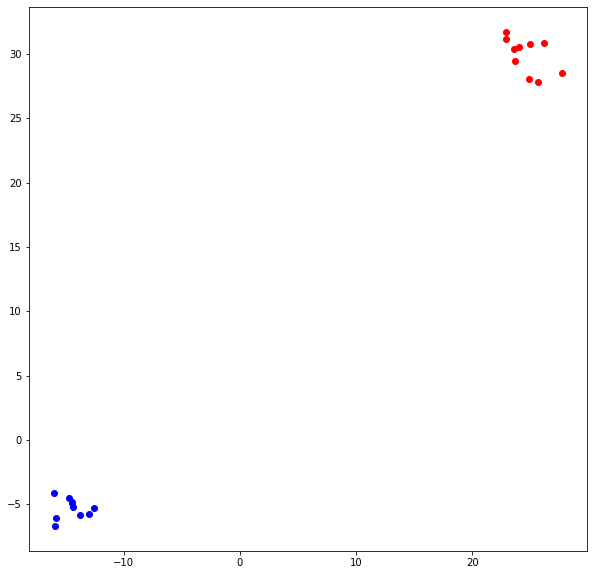

In [29]:
plt.figure(figsize=[10,10])

plt.errorbar(star1_pos[:, 0], star1_pos[:, 1], xerr=star1_unc[:, 0], yerr=star1_unc[:, 1], fmt='bo')
plt.errorbar(star2_pos[:, 0], star2_pos[:, 1], xerr=star2_unc[:, 0], yerr=star2_unc[:, 1], fmt='ro')
plt.show()

In [35]:
sep = np.sqrt( np.sum((star1_pos - star2_pos)**2, axis=1) )
sep

array([54.67113414, 53.19039169, 53.65204086, 52.50364565, 53.19967875,
       51.33897931, 51.93203793, 52.46256552, 50.78851561, 53.81460518])

In [38]:
def calculate_separation_distance(s1, s2, u1, u2):
    
    x1 = s1[:, 0]
    y1 = s1[:, 1]
    
    x2 = s2[:, 0]
    y2 = s2[:, 1]
    
    dx1 = u1[:, 0]
    dy1 = u1[:, 1]
    
    dx2 = u2[:, 0]
    dy2 = u2[:, 1]
    
    sep = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )
    
    dsep = np.sqrt(\
                  ((dx1**2 + dx2**2)*(x1-x2)**2 + (dy1**2+dy2**2)*(y1-y2)**2)/\
                  ((x1-x2)**2 + (y1-y2)**2))
    
    return sep, dsep

In [39]:
calculate_separation_distance(star1_pos, star2_pos, star1_unc, star2_unc)

(array([54.67113414, 53.19039169, 53.65204086, 52.50364565, 53.19967875,
        51.33897931, 51.93203793, 52.46256552, 50.78851561, 53.81460518]),
 array([0.00411486, 0.00418279, 0.00415895, 0.00410254, 0.0041551 ,
        0.00415494, 0.00425645, 0.00414841, 0.00421924, 0.00421289]))